__This notebook is meant to be run on an Amazon SageMaker notebook instance as it primarily uses SageMaker's built-in libraries and tools__

# Linear Learner Model
In this notebook, we will train and test a model using one of Amazon SageMaker's built-in algorithms, LinearLearner. Here is a link to the supervised model's official documentation https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html.

In [1]:
# Import libraries

import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

We store references to the current SageMaker instance's session, role, and bucket for later use.

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'data'

## Training

Next, we read in the data we preprocessed. Remember that for the train and validation dataset, we arrange it so that the first column is the data label - the price feature. This is a requirement by SageMaker's built-in algorithms when feeding it data in CSV format, however, for this notebook we will feed the data in through the RecordSet object. This is another format accepted by SageMaker algorithms which expects the labels and features to be formatted into a RecordSet object. For this reason, we will have to separate the datasets' labels and predictions.

In [4]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None).values
validation_data = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None).values

In [5]:
X_train = train_data[:,1:]
y_train = train_data[:,0]

X_validation = validation_data[:,1:]
y_validation = validation_data[:,0]

Here, we will instantiate the LinearLearner estimator. We provide it with an output path to which it will save the model artifacts and set its predictor type to _regressor_ in order for the output to be a single continuous value which will be its prediction for the car's price.

In [19]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'vehicles'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='regressor',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=300)

In [20]:
X_train_np = X_train.astype('float32')
y_train_np = y_train.astype('float32')

formatted_train_data = linear.record_set(X_train_np, labels=y_train_np)

X_validation_np = X_validation.astype('float32')
y_validation_np = y_validation.astype('float32')

formatted_validation_data = linear.record_set(X_validation_np, labels=y_validation_np, channel='validation')

We train the estimator with the train and validation set in RecordSet format.

In [21]:
linear.fit([formatted_train_data,formatted_validation_data])

2020-03-24 08:39:28 Starting - Starting the training job...
2020-03-24 08:39:30 Starting - Launching requested ML instances............
2020-03-24 08:41:29 Starting - Preparing the instances for training...........................
2020-03-24 08:46:09 Starting - Launched instance was unhealthy, replacing it!......
2020-03-24 08:47:08 Starting - Preparing the instances for training......
2020-03-24 08:48:28 Downloading - Downloading input data
2020-03-24 08:48:28 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/24/2020 08:48:44 INFO 140491301611328] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bia

If we take a look at the validation loss at the end of training, we can see that it is a ridiculously high number for a validation loss - 30230839.25. This loss value is this high because, unlike the training dataset, LinearLearner does not normalize the labels of the validation set. Our labels or car prices are usually in the 4000 to 12000 range so its no surprise that we arrive at such a value for the validation loss.

This, however, does not mean that our model is not learning at all. What we should be paying attention to is how much the validation loss has decreased throughout the training process. It has gone from 31856580.89 to 30230839.25 in 16 epochs.

## Evaluation

In order to make predictions from our trained model, we need to deploy it as an endpoint first.

In [22]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------!

We will use the _predict_ function below to run predictions on the deployed endpoint.

In [23]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def predict(predictor, features, batch_size=100):    
    prediction_batches = [predictor.predict(batch) for batch in chunks(features, batch_size)]
    
    predictions = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch])
                                  for batch in prediction_batches])
    
    return predictions

We load in the test dataset whose features and labels were kept in separate files.

In [24]:
X_test = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None).values
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None).values

X_test_np = X_test.astype('float32')
y_test_np = y_test.astype('float32')

In [25]:
predictions = predict(linear_predictor, X_test_np)

predictions

array([30272.62695312,  8655.7109375 , 17138.48828125, ...,
       22184.45898438, 36222.0859375 , 29559.05078125])

After acquiring the endpoint's predictions, we can now delete the endpoint.

In [26]:
linear_predictor.delete_endpoint()

In [27]:
labels = np.squeeze(y_test_np)

In [31]:
fig_dir = 'fig'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

We plot how close our model's predictions are to the actual car prices with a scatterplot. The closer the plot is to a _y = x_ function, the better.

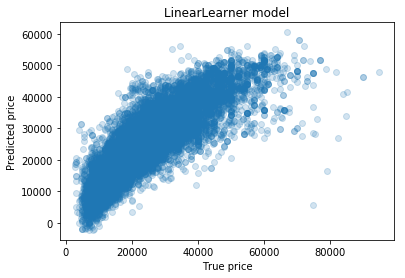

In [33]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("LinearLearner model")
plt.savefig(os.path.join(fig_dir, 'linearlearner_pred.jpg'))

As can be observed, the plot is more bent than straight implying that the LinearLearner model is overestimating the prices as the true price label increases.

### R-squared score

To represent how well the LinearLearner model performs in a numerical way, we will employ the R-squared algorithm. I find that this algorithm is the best to use as the accuracy metric of our model given that our model is of a linear regression objective. The R-squared score is basically the average of the distance between _x_(true price) and _y_(predicted price). You can read more about the R-squared score here https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit.

In [29]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.7372068518275521


Here we can see that our model's accuracy score on our test dataset is 0.74. The R-squared score can become negative but can also go as high as 1.0. Given that our score is over the 0.50 mark, we can say that our model did an okay job. We can also see below some metrics of our model's predictions.

In [30]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.3203125
Max distance: 69425.931640625
Mean distance: 3898.957455078954


Looking at these metrics, what stands out is the abnormally high max distance value. This value, and why it is actually good thing when the project's objective is kept in mind, will be explained on the conclusion of the PyTorch model notebook.

## What's next

Next up, we will be training an XGBoost model on the same datasets we used here and rate it by the same accuracy function and metrics.